### Прогнозирование невыполнения долговых обязательств клиентов банка по текущему кредиту 

In [1]:
from IPython.display import Image
Image(url= "kredit.jpg")

#### Целевая переменная:  Credit Default - факт невыполнения кредитных обязательств

#### __1__. Imports

In [2]:
import pandas as pd
import numpy as np
import itertools
import datetime
import math
import scikitplot as skplt
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': (12,6)})
matplotlib.rcParams["axes.grid"] = True

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('muted')

In [4]:
print('pandas    : ',pd.__version__)
print('numpy     : ',np.__version__)
print('matplotlib: ',matplotlib.__version__)
print('seaborn   : ',sns.__version__)

pandas    :  1.0.3
numpy     :  1.18.3
matplotlib:  3.1.3
seaborn   :  0.10.0


In [5]:
from tqdm import tqdm
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [6]:
pd.set_option('display.float_format', '{:.4f}'.format)

#### __2__. Data Loading and Analysis

In [7]:
df = pd.read_csv('course_project_train.csv')

In [8]:
df.shape

(7500, 17)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
# Пропущенные значения
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Annual Income (годовой доход) и Credit Score (кредитный рейтинг) имеют равное кол-во пропущенных значений - 1557

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0000,1366391.7202,845339.1996,164597.0000,844341.0000,1168386.0000,1640137.0000,10149344.0000
Tax Liens,7500.0000,0.0301,0.2716,0.0000,0.0000,0.0000,0.0000,7.0000
Number of Open Accounts,7500.0000,11.1309,4.9089,2.0000,8.0000,10.0000,14.0000,43.0000
Years of Credit History,7500.0000,18.3175,7.0419,4.0000,13.5000,17.0000,21.8000,57.7000
Maximum Open Credit,7500.0000,945153.7275,16026216.6709,0.0000,279229.5000,478159.0000,793501.5000,1304726170.0000
Number of Credit Problems,7500.0000,0.1700,0.4986,0.0000,0.0000,0.0000,0.0000,7.0000
Months since last delinquent,3419.0000,34.6926,21.6888,0.0000,16.0000,32.0000,50.0000,118.0000
Bankruptcies,7486.0000,0.1172,0.3472,0.0000,0.0000,0.0000,0.0000,4.0000
Current Loan Amount,7500.0000,11873177.4451,31926122.9747,11242.0000,180169.0000,309573.0000,519882.0000,99999999.0000
Current Credit Balance,7500.0000,289833.2352,317871.3824,0.0000,114256.5000,209323.0000,360406.2500,6506797.0000


In [12]:
# Обзор целевой переменной
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [13]:
# Наибольший открытый кредит > 100 млн.
df.loc[df['Maximum Open Credit'] > 100000000].T

,44,617,2617
Home Ownership,Have Mortgage,Home Mortgage,Home Mortgage
Annual Income,1334256.0000,NaN,3217802.0000
Years in current job,10+ years,3 years,10+ years
Tax Liens,0.0000,0.0000,0.0000
Number of Open Accounts,17.0000,13.0000,12.0000
Years of Credit History,15.4000,27.5000,35.5000
Maximum Open Credit,380052288.0000,1304726170.0000,265512874.0000
Number of Credit Problems,1.0000,0.0000,0.0000
Months since last delinquent,35.0000,NaN,NaN
Bankruptcies,0.0000,0.0000,0.0000


In [14]:
# Текущая сумма кредита > 800 тыс.
df.loc[df['Current Loan Amount'] > 800000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0000,NaN,0.0000,11.0000,26.3000,685960.0000,1.0000,nan,1.0000,debt consolidation,Short Term,99999999.0000,47386.0000,7914.0000,749.0000,0
2,Home Mortgage,751412.0000,8 years,0.0000,11.0000,35.0000,1182434.0000,0.0000,nan,0.0000,debt consolidation,Short Term,99999999.0000,308389.0000,13651.0000,742.0000,0
6,Home Mortgage,1511108.0000,10+ years,0.0000,9.0000,20.3000,388124.0000,0.0000,73.0000,0.0000,home improvements,Short Term,99999999.0000,51623.0000,2317.0000,745.0000,0
22,Rent,463790.0000,NaN,0.0000,6.0000,28.3000,288442.0000,0.0000,nan,0.0000,debt consolidation,Short Term,99999999.0000,157700.0000,5063.0000,738.0000,0
27,Rent,1004055.0000,8 years,0.0000,7.0000,14.5000,328394.0000,0.0000,nan,0.0000,debt consolidation,Short Term,99999999.0000,195966.0000,6041.0000,734.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0000,1 year,0.0000,12.0000,22.6000,2383260.0000,0.0000,nan,0.0000,debt consolidation,Short Term,99999999.0000,461054.0000,7386.0000,747.0000,0
7445,Home Mortgage,1564384.0000,6 years,0.0000,21.0000,17.3000,1545016.0000,0.0000,nan,0.0000,other,Long Term,99999999.0000,1043442.0000,32461.0000,728.0000,0
7464,Home Mortgage,1159152.0000,6 years,0.0000,14.0000,22.0000,389356.0000,1.0000,77.0000,1.0000,debt consolidation,Short Term,99999999.0000,49438.0000,18257.0000,737.0000,0
7475,Rent,848426.0000,10+ years,0.0000,8.0000,20.1000,526306.0000,0.0000,12.0000,0.0000,debt consolidation,Short Term,99999999.0000,83638.0000,16473.0000,742.0000,0


In [15]:
# Налоговые обременения
df['Tax Liens'].value_counts()

0.0000    7366
1.0000      83
2.0000      30
3.0000      10
4.0000       6
5.0000       2
6.0000       2
7.0000       1
Name: Tax Liens, dtype: int64

In [16]:
# Тестовые данные
dft = pd.read_csv('course_project_test.csv')

In [17]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [18]:
# Пропущенные значения Test
dft.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Annual Income (годовой доход) и Credit Score (кредитный рейтинг) также имеют равное кол-во пропущенных значений - 513

In [19]:
dft.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0000,1366921.6759,917125.1512,106533.0000,852311.5000,1178475.0000,1629734.5000,14975610.0000
Tax Liens,2500.0000,0.0352,0.3863,0.0000,0.0000,0.0000,0.0000,15.0000
Number of Open Accounts,2500.0000,11.1844,4.8528,1.0000,8.0000,10.0000,14.0000,48.0000
Years of Credit History,2500.0000,18.3259,7.2547,3.9000,13.4000,17.0000,22.1000,53.4000
Maximum Open Credit,2500.0000,710570.4056,1511983.4839,0.0000,278586.0000,478676.0000,802598.5000,54484386.0000
Number of Credit Problems,2500.0000,0.1620,0.5599,0.0000,0.0000,0.0000,0.0000,15.0000
Months since last delinquent,1142.0000,34.1813,22.0243,0.0000,16.0000,30.0000,50.0000,82.0000
Bankruptcies,2497.0000,0.1069,0.3572,0.0000,0.0000,0.0000,0.0000,5.0000
Current Loan Amount,2500.0000,12155719.6332,32260973.7200,15422.0000,187126.5000,322366.0000,522582.5000,99999999.0000
Current Credit Balance,2500.0000,296396.6484,378301.9662,0.0000,110114.5000,207385.0000,366348.5000,6030087.0000


In [20]:
# Сделаем выборку данных, где задан кредитный рейтинг
df_temp = df.loc[~df['Credit Score'].isnull()].copy()
df_temp.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             296
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    3207
Bankruptcies                      12
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
dtype: int64

In [21]:
df_temp['Bankruptcies'].fillna(-1, inplace = True)
df_temp['Months since last delinquent'].fillna(-1, inplace = True)

#### График зависимости кредитного рейтинга от прочих числовых признаков

In [22]:
matplotlib.rcParams.update({'figure.figsize': (12,6)})

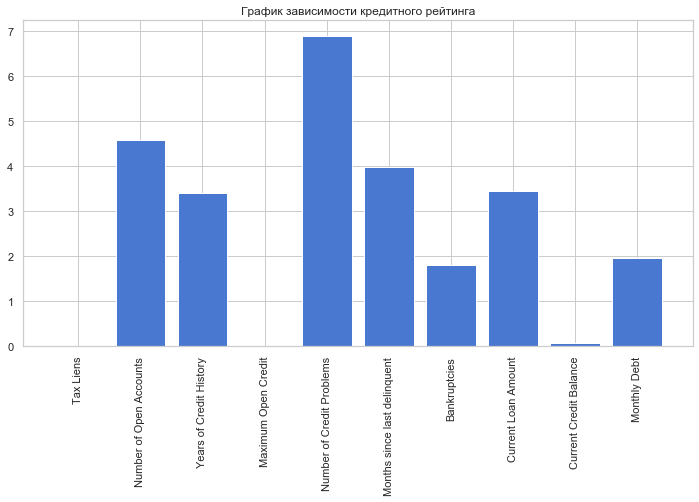

In [23]:
predictors = ['Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
              'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
              'Current Credit Balance', 'Monthly Debt']
selector = SelectKBest(f_classif, k='all')
selector.fit(df_temp[predictors], df_temp['Credit Score'])
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.title('График зависимости кредитного рейтинга')
plt.show()

In [24]:
# Количество проблем с кредитом (Train)
df['Number of Credit Problems'].value_counts()

0.0000    6469
1.0000     882
2.0000      93
3.0000      35
4.0000       9
5.0000       7
6.0000       4
7.0000       1
Name: Number of Credit Problems, dtype: int64

In [25]:
# Количество проблем с кредитом (Test)
dft['Number of Credit Problems'].value_counts()

0.0000     2177
1.0000      280
2.0000       29
3.0000        7
5.0000        4
15.0000       1
4.0000        1
7.0000        1
Name: Number of Credit Problems, dtype: int64

In [26]:
print(f'Макс колич. открытых счетов (train): {max(df["Number of Open Accounts"])}')
print(f'Макс колич. открытых счетов (test ): {max(dft["Number of Open Accounts"])}')

Макс колич. открытых счетов (train): 43.0
Макс колич. открытых счетов (test ): 48.0


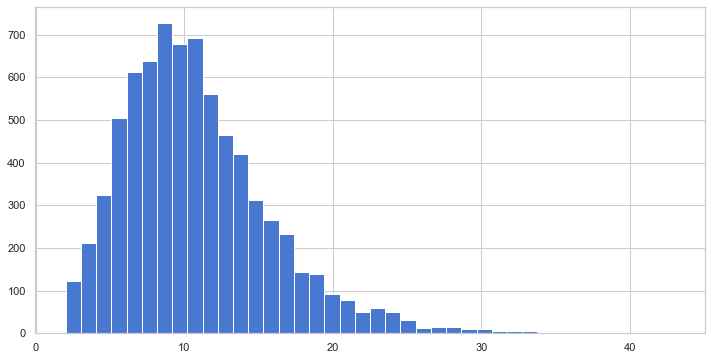

In [27]:
# Количество открытых счетов
df['Number of Open Accounts'].hist(bins=40)

In [28]:
# Годовой доход > 9 млн.
df.loc[df['Annual Income'] > 9000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2200,Rent,9338880.0000,10+ years,0.0000,7.0000,7.3000,1092608.0000,0.0000,nan,0.0000,business loan,Short Term,788480.0000,326496.0000,40546.0000,720.0000,0
6472,Rent,10149344.0000,5 years,0.0000,10.0000,17.5000,270380.0000,0.0000,22.0000,0.0000,debt consolidation,Short Term,664818.0000,205713.0000,61235.0000,692.0000,0


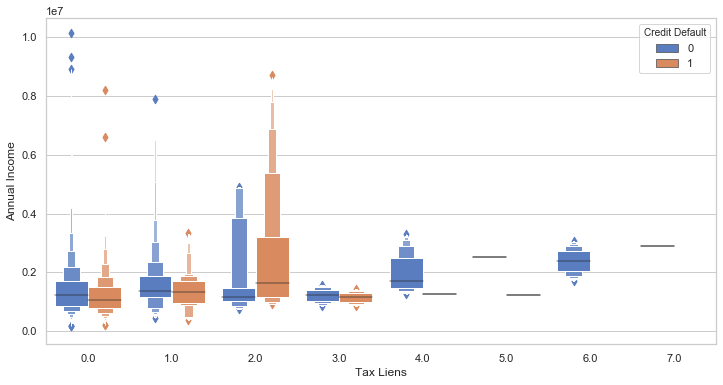

In [29]:
# Налоговые обременения (Tax Liens) и Факт невыполнения кредитных обязательств (Credit Default)
ax = sns.boxenplot(x="Tax Liens", y="Annual Income", hue="Credit Default", data=df)

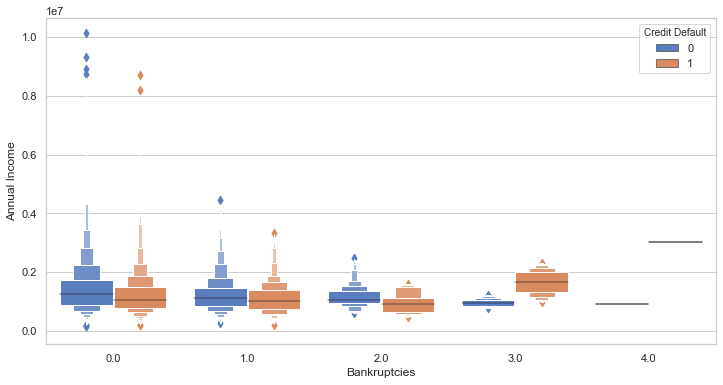

In [30]:
# Кол-во банкротств (Bankruptcies) и Факт невыполнения кредитных обязательств (Credit Default)
ax = sns.boxenplot(x="Bankruptcies", y="Annual Income", hue="Credit Default", data=df)

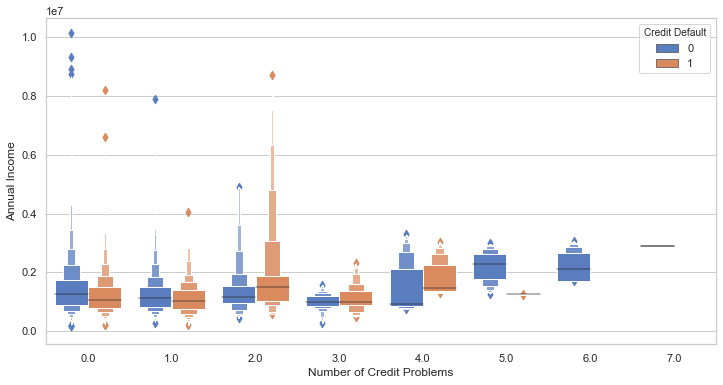

In [31]:
# Кол-во проблем с кредитом (Number of Credit Problems) и Факт невыполнения кредитных обязательств (Credit Default)
ax = sns.boxenplot(x="Number of Credit Problems", y="Annual Income", hue="Credit Default", data=df)

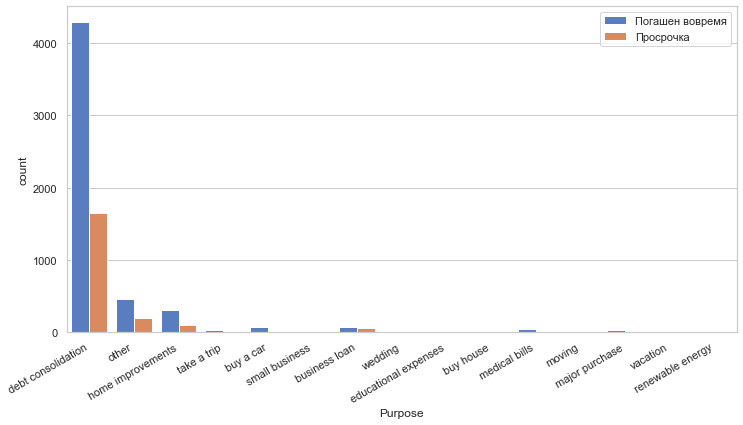

In [32]:
# Соотношение просрочек/погашений по Целям кредита
labels = ["Погашен вовремя", "Просрочка"]
ax = sns.countplot(x="Purpose", hue="Credit Default", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.legend(labels, loc=1)

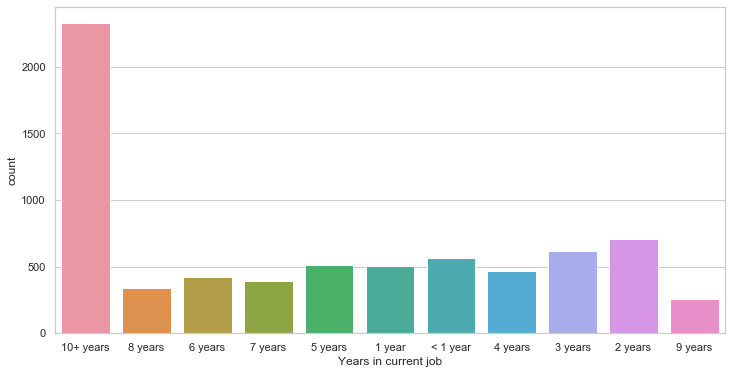

In [33]:
# Количество лет на текущем месте работы
sns.countplot(df['Years in current job'])

In [34]:
# Текущий кредитный баланс > 5 млн.
df.loc[df['Current Credit Balance'] > 5000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4769,Home Mortgage,3739960.0000,9 years,0.0000,7.0000,22.8000,26343328.0000,0.0000,nan,0.0000,home improvements,Short Term,757834.0000,6506797.0000,38023.0000,703.0000,0


In [35]:
# Обзор объектных признаков (Train)
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n' + '=' * 20 + '\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Term


In [36]:
# Обзор объектных признаков (Test)
for cat_colname in dft.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n' + '=' * 20 + '\n' + str(dft[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership
Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************

Years in current job
10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************

Purpose
debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64
****************************************

Term
Short Term    1861
Long Term      639
Na

In [37]:
# Сколько значений имеют кредитный  рейтинг > 800
df.loc[df['Credit Score'] > 800, 'Credit Score'].count()

400

In [38]:
# Минимальное из этих значений
min(df.loc[df['Credit Score'] > 800, 'Credit Score'])

6060.0

Предположительно такие значения являются выбросами (увеличение от истинного значения в 10 раз)

#### __3__. Data processing

In [39]:
# Подготовка данных
def prep(df):
    # Банкротства
    df["Bankruptcies"].fillna(-1, inplace = True)
    # Количество месяцев с последней просрочки платежа
    df['Months since last delinquent'].fillna(-1, inplace = True)    
    #df = df.drop('Months since last delinquent', axis=1)
    
    # Количество проблем с кредитом
    df.loc[df['Number of Credit Problems'] > 5.0, 'Number of Credit Problems'] = 6.0   
    
    # Домовладение: Ипотека, Наём, Собственное 
    df['Home'] = df['Home Ownership'].map({'Home Mortgage': 'Mort', 'Have Mortgage': 'Mort', 'Rent': 'Rent', 'Own Home': 'Own'})
    df = df.drop('Home Ownership', axis=1)
  
    # Кол-во лет на текущей работе
    df['Years in current job'].fillna('10+ years', inplace = True)
    df['Job'] = df['Years in current job'].map({'< 1 year':'0', '1 year':'1', '2 years':'2', '3 years':'3', '4 years':'4',
            '5 years':'5', '6 years':'6', '7 years':'7', '8 years':'8', '9 years':'9', '10+ years':'10'})
    df = df.drop('Years in current job', axis=1)
    
    # Срок кредита
 #   df['Term'] = df['Term'].map({'Short Term': 0, 'Long Term': 1})

    # Текущая сумма кредита
    df['CLA9'] = 0
    df.loc[df['Current Loan Amount'] == 99999999.0, 'CLA9'] = 1
    df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = 1.0
    df.loc[df['Current Loan Amount'] > 800000.0, 'Current Loan Amount'] = 800000.0
    
    # Наибольший открытый кредит
    df.loc[df['Maximum Open Credit'] > 2000000.0, 'Maximum Open Credit'] = 2000000.0
    
    # Текущий кредитный баланс
    df.loc[df['Current Credit Balance'] > 1500000.0, 'Current Credit Balance'] = 1500000.0
    
    # Годовой доход
    df.loc[df['Annual Income'] > 9000000.0, 'Annual Income'] = 9000000.0
    
    # Кредитный рейтинг
    df.loc[df['Credit Score'] > 800, 'Credit Score'] = df['Credit Score'] * 0.1
    
    # Кредитный рейтинг - вычислим незаполненные по средним знач. от 'Number of Open Accounts' и 'Number of Credit Problems'
    df_cs = df.loc[~df['Credit Score'].isnull()].copy()
    cs_mean = df_cs.groupby(['Number of Open Accounts','Number of Credit Problems'],\
                            as_index=False)[['Credit Score']].mean().rename(columns={'Credit Score':'Score'}).copy()
    cs_mean['Score'] = cs_mean.Score.interpolate(method='linear')
    df = pd.merge(df, cs_mean, on=['Number of Open Accounts','Number of Credit Problems'], how='left').set_index(df.index)
    csore_med = df['Score'].mean()
    df['Score'] = df['Score'].fillna(csore_med)
    df['Credit Score'].fillna(df['Score'], inplace = True)

    # Годовой доход - вычислим незаполненные по средним знач. от 'Number of Open Accounts' и 'Number of Credit Problems'
    an_mean = df_cs.groupby(['Number of Open Accounts','Number of Credit Problems'],\
                            as_index=False)[['Annual Income']].mean().rename(columns={'Annual Income':'Ann_Mean'}).copy()
    an_mean['Ann_Mean'] = an_mean.Ann_Mean.interpolate(method='linear')
    df = pd.merge(df, an_mean, on=['Number of Open Accounts','Number of Credit Problems'], how='left').set_index(df.index)
    Annual_med = df['Ann_Mean'].mean()
    df['Ann_Mean'] = df['Ann_Mean'].fillna(Annual_med)
    df["Annual Income"].fillna(df['Ann_Mean'], inplace = True)         # Заполним пропущенные значения средними   
    
    df = df.drop('Score', axis=1)
    df = df.drop('Ann_Mean', axis=1)    
    return df

In [40]:
df = pd.read_csv('course_project_train.csv')
# До обработки - удалим незаполненные значения "Credit Score", когда 'Credit Default' = 0
# для балансировки целевого класса 'Credit Default'(1)
df_temp = df.loc[(df['Credit Score'].isnull()) & (df['Credit Default'] == 0)]
df.drop(index=df_temp.index, inplace=True)

In [41]:
df_ = prep(df)

In [42]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6472 entries, 0 to 7497
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 6472 non-null   float64
 1   Tax Liens                     6472 non-null   float64
 2   Number of Open Accounts       6472 non-null   float64
 3   Years of Credit History       6472 non-null   float64
 4   Maximum Open Credit           6472 non-null   float64
 5   Number of Credit Problems     6472 non-null   float64
 6   Months since last delinquent  6472 non-null   float64
 7   Bankruptcies                  6472 non-null   float64
 8   Purpose                       6472 non-null   object 
 9   Term                          6472 non-null   object 
 10  Current Loan Amount           6472 non-null   float64
 11  Current Credit Balance        6472 non-null   float64
 12  Monthly Debt                  6472 non-null   float64
 13  Cre

In [43]:
df_.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,6472.0000,1366481.4059,809924.5863,164597.0000,865868.0000,1224151.0000,1606388.2500,9000000.0000
Tax Liens,6472.0000,0.0318,0.2811,0.0000,0.0000,0.0000,0.0000,7.0000
Number of Open Accounts,6472.0000,11.1465,4.8975,2.0000,8.0000,10.0000,14.0000,43.0000
Years of Credit History,6472.0000,18.2845,7.0648,4.0000,13.5000,17.0000,21.8000,57.7000
Maximum Open Credit,6472.0000,603594.8483,458333.9941,0.0000,276765.5000,475662.0000,788447.0000,2000000.0000
Number of Credit Problems,6472.0000,0.1740,0.5077,0.0000,0.0000,0.0000,0.0000,6.0000
Months since last delinquent,6472.0000,15.5422,23.1927,-1.0000,-1.0000,-1.0000,30.0000,118.0000
Bankruptcies,6472.0000,0.1171,0.3549,-1.0000,0.0000,0.0000,0.0000,4.0000
Current Loan Amount,6472.0000,271939.3198,201921.2502,1.0000,121478.5000,237347.0000,400290.0000,789030.0000
Current Credit Balance,6472.0000,282331.8177,256102.6468,0.0000,114166.2500,211042.5000,361950.0000,1500000.0000


In [44]:
df_['CLA9'].value_counts()

0    5602
1     870
Name: CLA9, dtype: int64

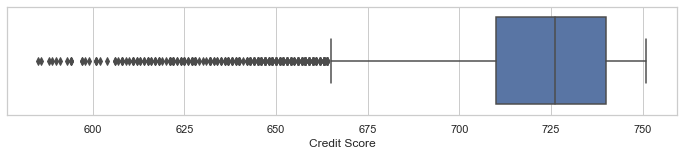

In [45]:
# Кредитный рейнинг
sns.set_palette("deep")
plt.figure(figsize=(12, 2))
sns.boxplot(df_['Credit Score'], orient="h")

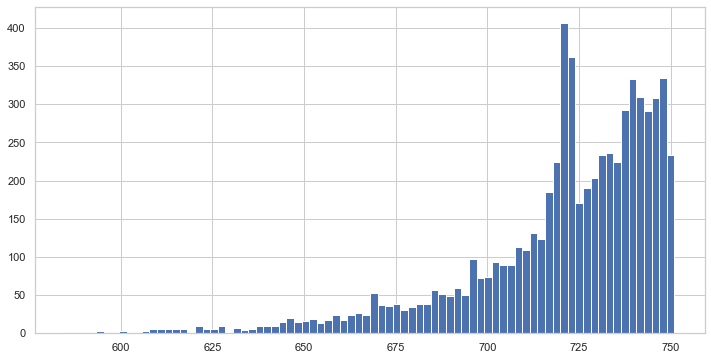

In [46]:
# Кредитный рейнинг (гистограмма)
df_['Credit Score'].hist(bins=80)

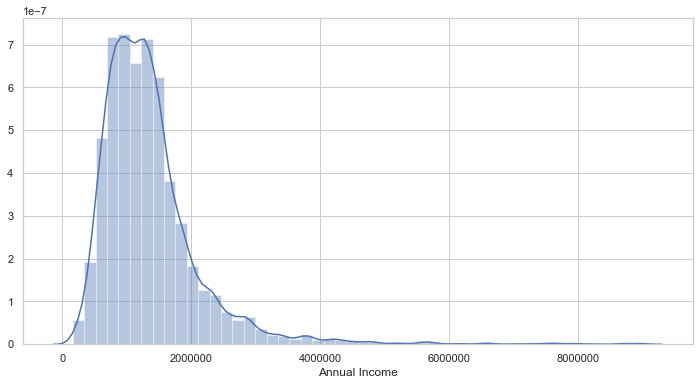

In [47]:
# Распределение Годового дохода
sns.distplot(df_["Annual Income"])

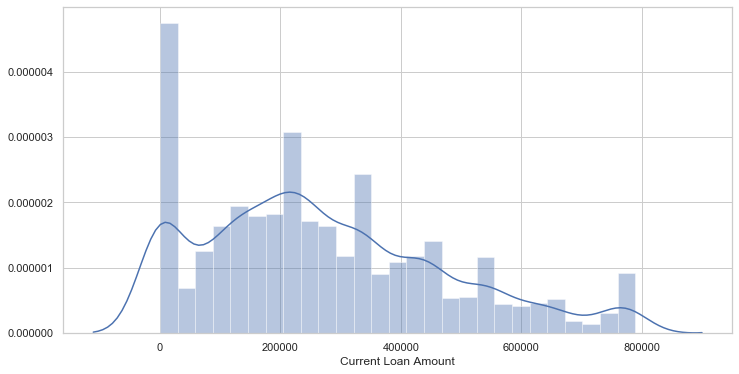

In [48]:
# Распределение Текущей суммы кредита
sns.distplot(df_["Current Loan Amount"])

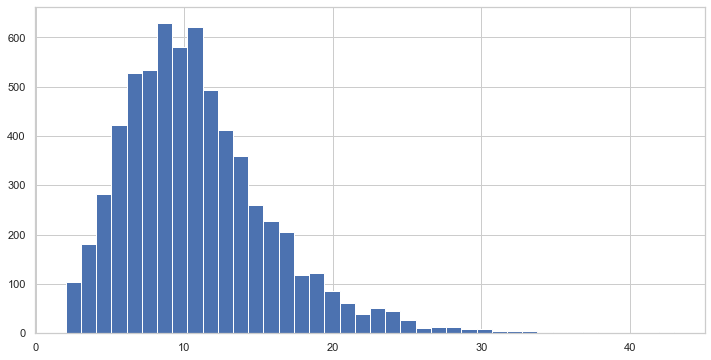

In [49]:
# Количество открытых кредитов
df_['Number of Open Accounts'].hist(bins=40)

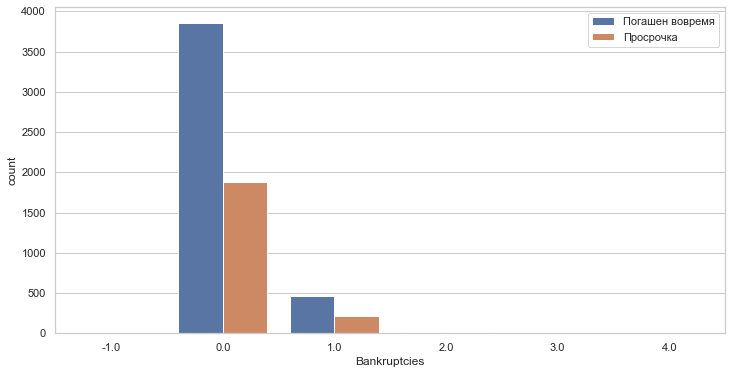

In [50]:
# Соотношение просрочек/погашений по Количеству банкротств
labels = ["Погашен вовремя", "Просрочка"]
ax = sns.countplot(x="Bankruptcies", hue="Credit Default", data=df_)
ax.legend(labels)

In [51]:
# Есть ли пропущенные значения после обработки?
df_.isnull().sum()

Annual Income                   0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Home                            0
Job                             0
CLA9                            0
dtype: int64

In [52]:
# Корреляция признаков с целевой колонкой
corr_f = df_.corr()['Credit Default']
corr_fs = corr_f[corr_f.abs() > 0.01].sort_values(ascending=False)
corr_fs

Credit Default               1.0000
Current Loan Amount          0.1887
Number of Open Accounts      0.0300
Tax Liens                    0.0220
Monthly Debt                 0.0192
Number of Credit Problems    0.0165
Current Credit Balance      -0.0151
Years of Credit History     -0.0195
Maximum Open Credit         -0.0696
Annual Income               -0.0908
Credit Score                -0.1875
CLA9                        -0.2744
Name: Credit Default, dtype: float64

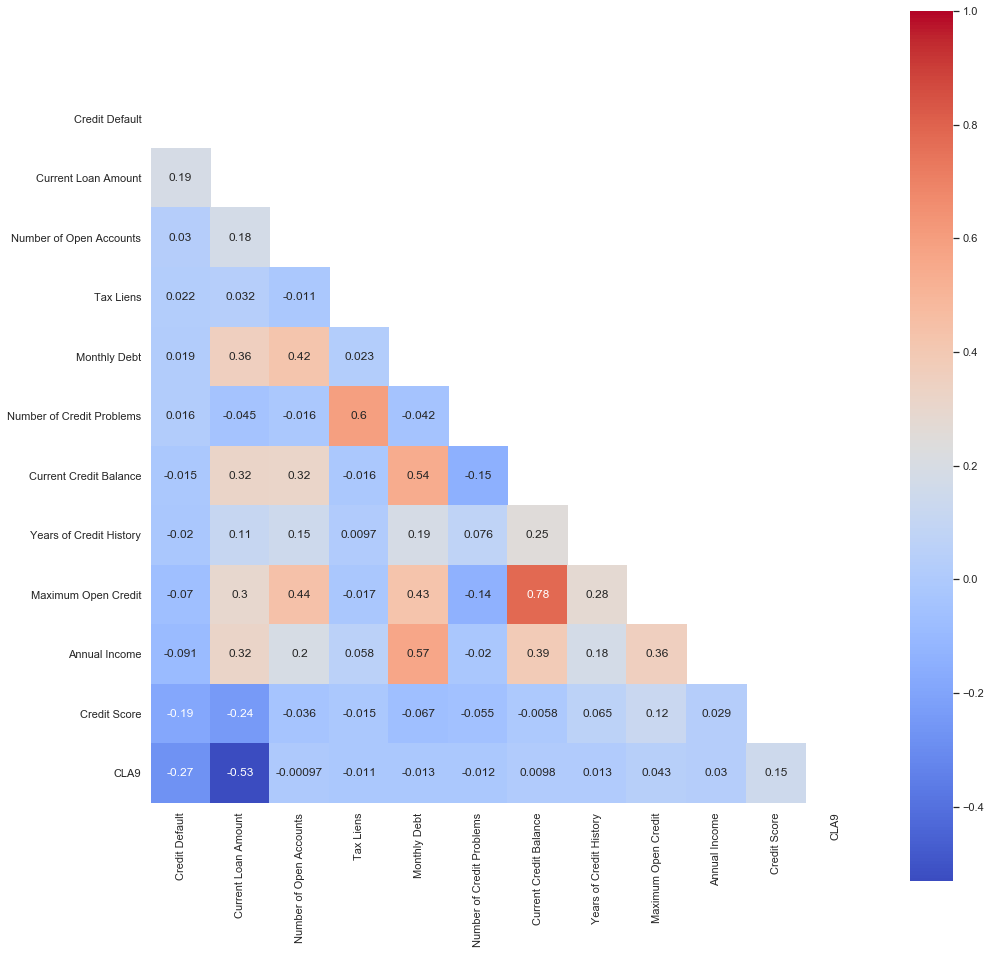

In [53]:
# График зависимостей признаков
dfc = df_.loc[:, corr_fs.index]
mask = np.zeros_like(dfc.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 16))
#sns.heatmap(dfc.corr(), cmap='coolwarm',annot=True)
with sns.axes_style("white"):
    ax = sns.heatmap(dfc.corr(), cmap='coolwarm', annot=True, mask=mask, square=True)

In [54]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6472 entries, 0 to 7497
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 6472 non-null   float64
 1   Tax Liens                     6472 non-null   float64
 2   Number of Open Accounts       6472 non-null   float64
 3   Years of Credit History       6472 non-null   float64
 4   Maximum Open Credit           6472 non-null   float64
 5   Number of Credit Problems     6472 non-null   float64
 6   Months since last delinquent  6472 non-null   float64
 7   Bankruptcies                  6472 non-null   float64
 8   Purpose                       6472 non-null   object 
 9   Term                          6472 non-null   object 
 10  Current Loan Amount           6472 non-null   float64
 11  Current Credit Balance        6472 non-null   float64
 12  Monthly Debt                  6472 non-null   float64
 13  Cre

In [55]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.8, 15):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [56]:
CAT_FEATURE_NAMES = ['Home', 'Purpose', 'Job', 'Term', 'CLA9']
for colname in CAT_FEATURE_NAMES:
    df_[colname] = pd.Categorical(df_[colname])
    
df_[CAT_FEATURE_NAMES].dtypes

Home       category
Purpose    category
Job        category
Term       category
CLA9       category
dtype: object

In [57]:
# Обзор целевой переменной
df_['Credit Default'].value_counts()

0    4359
1    2113
Name: Credit Default, dtype: int64

In [58]:
# Подготовим данные для модели
X = df_.loc[:,df_.columns != 'Credit Default']
y = df_.loc[:,df_.columns == 'Credit Default'].to_numpy()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [60]:
model_catb = CatBoostClassifier(iterations=100, max_depth=4, class_weights={0: 1.0, 1: 2.0}, eval_metric='F1',
                                verbose=10, random_state=37, use_best_model=True)
model_catb.fit(X_train, y_train, CAT_FEATURE_NAMES, eval_set=(X_test, y_test))

Learning rate set to 0.127461
0:	learn: 0.7140776	test: 0.7240719	best: 0.7240719 (0)	total: 63.3ms	remaining: 6.26s
10:	learn: 0.6939072	test: 0.7023411	best: 0.7240719 (0)	total: 88.9ms	remaining: 720ms
20:	learn: 0.7004207	test: 0.7070623	best: 0.7240719 (0)	total: 113ms	remaining: 426ms
30:	learn: 0.7022415	test: 0.7180342	best: 0.7240719 (0)	total: 133ms	remaining: 297ms
40:	learn: 0.7068461	test: 0.7175117	best: 0.7240719 (0)	total: 154ms	remaining: 221ms
50:	learn: 0.7093075	test: 0.7196581	best: 0.7240719 (0)	total: 176ms	remaining: 169ms
60:	learn: 0.7108893	test: 0.7112646	best: 0.7240719 (0)	total: 199ms	remaining: 127ms
70:	learn: 0.7146431	test: 0.7214808	best: 0.7240719 (0)	total: 218ms	remaining: 89.1ms
80:	learn: 0.7158454	test: 0.7230571	best: 0.7240719 (0)	total: 240ms	remaining: 56.2ms
90:	learn: 0.7160018	test: 0.7258621	best: 0.7258621 (90)	total: 261ms	remaining: 25.8ms
99:	learn: 0.7162846	test: 0.7202073	best: 0.7277419 (91)	total: 279ms	remaining: 0us

bestTest

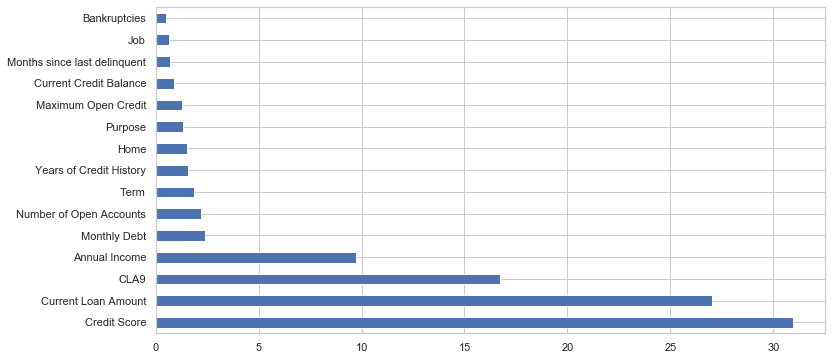

In [61]:
# Выведем график 15-ти наиболее важных признаков (относительно целевого "Credit Default")
feat_importances = pd.Series(model_catb.get_feature_importance(), index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [62]:
y_pred = model_catb.predict(X_test)
y_pred_probs = model_catb.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1075
           1       0.52      0.78      0.62       543

    accuracy                           0.68      1618
   macro avg       0.68      0.71      0.67      1618
weighted avg       0.74      0.68      0.69      1618



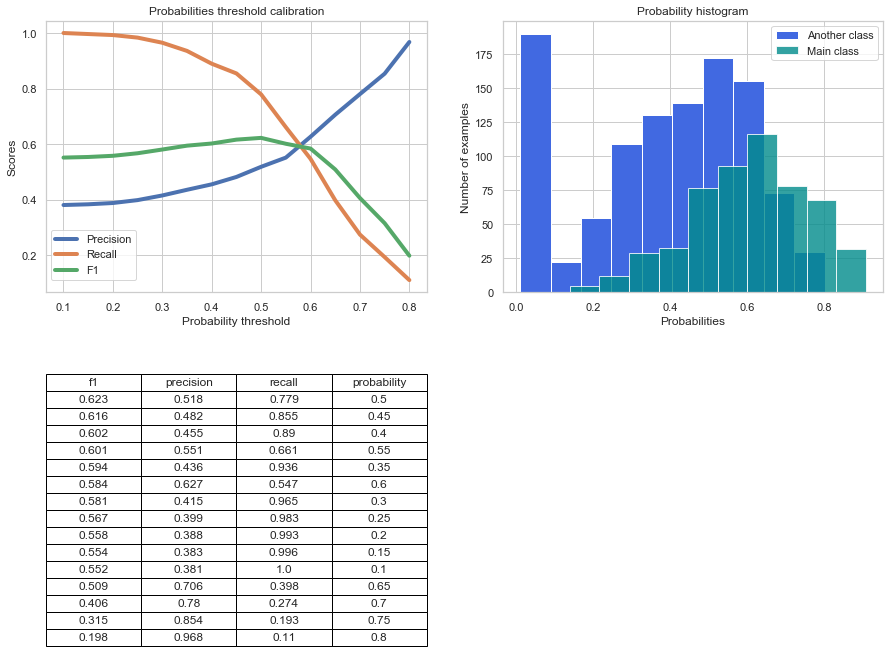

In [63]:
show_proba_calibration_plots(y_pred_probs[:, 1], y_test)

In [66]:
model_catb = CatBoostClassifier(iterations=100, max_depth=4, class_weights={0: 1.0, 1: 2.0}, eval_metric='F1',
                                verbose=10, random_state=37)
model_catb.fit(X, y, CAT_FEATURE_NAMES)

Learning rate set to 0.188907
0:	learn: 0.6926053	total: 9.23ms	remaining: 914ms
10:	learn: 0.6908647	total: 37.6ms	remaining: 304ms
20:	learn: 0.6990161	total: 60.8ms	remaining: 229ms
30:	learn: 0.7013686	total: 83.8ms	remaining: 187ms
40:	learn: 0.7071181	total: 105ms	remaining: 151ms
50:	learn: 0.7136594	total: 127ms	remaining: 122ms
60:	learn: 0.7166667	total: 149ms	remaining: 95.1ms
70:	learn: 0.7174036	total: 173ms	remaining: 70.5ms
80:	learn: 0.7188353	total: 194ms	remaining: 45.6ms
90:	learn: 0.7274378	total: 217ms	remaining: 21.4ms
99:	learn: 0.7354605	total: 236ms	remaining: 0us


In [67]:
y_pred = model_catb.predict(X_test)
y_pred_probs = model_catb.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1075
           1       0.57      0.79      0.66       543

    accuracy                           0.73      1618
   macro avg       0.72      0.75      0.72      1618
weighted avg       0.77      0.73      0.74      1618



#### Подготовка и предсказание на тестовом наборе данных

In [68]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [69]:
# Обработка данных
df_test = prep(dft)

In [70]:
for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])

In [71]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 2500 non-null   float64 
 1   Tax Liens                     2500 non-null   float64 
 2   Number of Open Accounts       2500 non-null   float64 
 3   Years of Credit History       2500 non-null   float64 
 4   Maximum Open Credit           2500 non-null   float64 
 5   Number of Credit Problems     2500 non-null   float64 
 6   Months since last delinquent  2500 non-null   float64 
 7   Bankruptcies                  2500 non-null   float64 
 8   Purpose                       2500 non-null   category
 9   Term                          2500 non-null   category
 10  Current Loan Amount           2500 non-null   float64 
 11  Current Credit Balance        2500 non-null   float64 
 12  Monthly Debt                  2500 non-null   fl

In [72]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,2500.0000,1357496.7524,752762.4421,106533.0000,934776.2500,1266912.6250,1574102.5000,9000000.0000
Tax Liens,2500.0000,0.0352,0.3863,0.0000,0.0000,0.0000,0.0000,15.0000
Number of Open Accounts,2500.0000,11.1844,4.8528,1.0000,8.0000,10.0000,14.0000,48.0000
Years of Credit History,2500.0000,18.3259,7.2547,3.9000,13.4000,17.0000,22.1000,53.4000
Maximum Open Credit,2500.0000,615194.6984,471339.9397,0.0000,278586.0000,478676.0000,802598.5000,2000000.0000
Number of Credit Problems,2500.0000,0.1580,0.4837,0.0000,0.0000,0.0000,0.0000,6.0000
Months since last delinquent,2500.0000,15.0708,22.9939,-1.0000,-1.0000,-1.0000,27.0000,82.0000
Bankruptcies,2500.0000,0.1056,0.3590,-1.0000,0.0000,0.0000,0.0000,5.0000
Current Loan Amount,2500.0000,275719.8708,199136.0594,1.0000,124536.5000,257103.0000,398893.0000,789096.0000
Current Credit Balance,2500.0000,280440.7196,258107.8269,0.0000,110114.5000,207385.0000,366348.5000,1500000.0000


In [73]:
# Предсказание
y_pred = model_catb.predict(df_test)

In [74]:
y_pred.shape

(2500,)

#### __6__. Saving the result

In [78]:
dfr = pd.DataFrame(columns = ['Index','Credit Default'])
dfr['Index'] = [x for x in range(2500)]
dfr['Credit Default'] = y_pred

In [79]:
dfr.to_csv('ISamoylenko_predictions.csv', index=False, encoding='utf-8')

In [80]:
dfr['Credit Default'].value_counts()

1    1334
0    1166
Name: Credit Default, dtype: int64